<a href="https://colab.research.google.com/github/mit1280/Document-AI/blob/main/Fine_tune_KOSMOS_2_for_multimodal_grounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inference with KOSMOS-2 for multimodal grounding and referral

In this notebook, we'll perform inference with Microsoft's new impressive multimodal large language model (LLM) called [KOSMOS-2](https://huggingface.co/docs/transformers/main/en/model_doc/kosmos-2). KOSMOS-2 follows a decoder-only Transformer architecture (like any other LLM like LLaMa-2 or Mistral-7b), but is trained on interleaved text and images, where the text contains references to objects in the images in the form of bounding boxes expressed as special tokens.

Note: this notebook requires a GPU. I'm personally using a high RAM notebook with a V100 GPU (I'm using Colab Pro).

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/kosmos_2_architecture.jpg"
alt="drawing" width="600"/>

<small> Overview of KOSMOS-2. Taken from the <a href="https://arxiv.org/abs/2306.14824">original paper</a>. </small>

https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L619

https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L2924

https://discuss.huggingface.co/t/how-is-the-data-shifted-by-one-token-during-causallm-fine-tuning/36386

https://github.com/huggingface/transformers/blob/b2748a6efd045dd771f8fd48e8b309cbc061c618/src/transformers/models/kosmos2/__init__.py

https://github.com/microsoft/unilm/blob/master/kosmos-2/fairseq/fairseq/logging/metrics.py

https://github.com/huggingface/transformers/blob/main/src/transformers/trainer_pt_utils.py#L482

## Set-up environment

Let's start by installing 🤗 Transformers. We install from main here since the model is brand new at the time of writing. We also install Accelerate and Bitsandbytes since those will provide [4-bit inference](https://huggingface.co/blog/4bit-transformers-bitsandbytes), greatly reducing the memory requirements to load the model (without those I wouldn't be able to load the model in Google Colab).

In [ ]:
!pip install -q -U transformers accelerate bitsandbytes bitsandbytes seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
# !pip install -q  trl peft loralib rouge_score flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import requests
from datasets import load_dataset
from datasets.features import ClassLabel
import re
from PIL import Image, ImageDraw, ImageFont
import math
import random
from transformers import Kosmos2Config, Kosmos2Model



> The image resolution is set to 1280×1280 and the patch size is 10×10. We divide the width and height of the image into 256 bins, with each bin consisting of 5×5 pixels. A total of 256×256 location tokens are added to the vocabulary.



In [ ]:
# Initializing a Kosmos-2 kosmos-2-patch14-224 style configuration
configuration = Kosmos2Config(
      text_config = {"max_position_embeddings" : 2048*2, "attention_heads" : 32*4},
      vision_config = {"image_size" : 1280, "patch_size" : 256}
    )
# configuration

In [ ]:
from transformers import Kosmos2ForConditionalGeneration
from transformers import Kosmos2Config, Kosmos2Model, AutoProcessor

# configuration = Kosmos2Config(latent_query_num = 64 * 4)
# model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224", config = configuration, ignore_mismatched_sizes=True)
model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224", device_map="auto")
# num_patches_per_side = 32*math.sqrt(total_tokens_increase_by)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# total_tokens_increase_by = 64
# # , num_patch_index_tokens = 1024 * total_tokens_increase_by
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224", add_eos_token=True, device_map="auto")
# # model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", load_in_4bit=True,device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load model

Next, let's load the model along with its processor. We specify `load_in_4bit=True` to reduce the size of the weights to be able to load the model in Google Colab. This is all thanks to the magic of bitsandbytes' integration in the Transformers library (see [this blog post](https://huggingface.co/blog/4bit-transformers-bitsandbytes) for all info). We also specify to place the model on the GPU (with id=0, meaning the first GPU on our system).

In [ ]:
dataset_id ="pierreguillou/DocLayNet-small"

dataset = load_dataset(dataset_id, trust_remote_code=True)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 691
Test dataset size: 49


In [ ]:
# Remove data which has no text
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/kosmos2/processing_kosmos2.py#L154
dataset = dataset.filter(lambda example: len(example['texts']) > 0)

In [ ]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "texts"
boxes_column_name = "bboxes_block"
label_column_name = "categories"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
id2label

{0: 'Caption',
 1: 'Footnote',
 2: 'Formula',
 3: 'List-item',
 4: 'Page-footer',
 5: 'Page-header',
 6: 'Picture',
 7: 'Section-header',
 8: 'Table',
 9: 'Text',
 10: 'Title'}

In [ ]:
# Define colors for all labels
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(label_list))
font = ImageFont.load_default()
label2color = {label: colors[idx] for idx, label in enumerate(label_list)}

In [ ]:
# Normalize box diamentions to range 0 to 1000
def normalized_box(box, image_width=1025, image_height=1025):
    return [
        round(float(box[0] / image_width), 6),
        round(float(box[1] / image_height), 6),
        round(float(box[2] / image_width), 6),
        round(float(box[3] / image_height), 6),
    ]

def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h] # we need to convert it into (x1, y1, x2, y2) which is (left, top, left+widght, top+height)

In [ ]:
# copied from https://github.com/microsoft/unilm/blob/97e4923e97d3ee10b57e97013556e3fd0d207a9b/kosmos-2/demo/decode_string.py#L35C1-L75C38
# (with format modifications)
def patch_index_to_coordinate(ul_idx: int, lr_idx: int, num_patches_per_side: int):
    # Compute the size of each cell in the grid
    cell_size = 1.0 / num_patches_per_side

    # Compute the x and y indices of the upper-left and lower-right corners of the bounding box
    ul_x = ul_idx % num_patches_per_side
    ul_y = ul_idx // num_patches_per_side

    lr_x = lr_idx % num_patches_per_side
    lr_y = lr_idx // num_patches_per_side

    # Compute the normalized coordinates of the bounding box
    if ul_idx == lr_idx:
        x1 = ul_x * cell_size
        y1 = ul_y * cell_size
        x2 = lr_x * cell_size + cell_size
        y2 = lr_y * cell_size + cell_size
    elif ul_x == lr_x or ul_y == lr_y:
        x1 = ul_x * cell_size
        y1 = ul_y * cell_size
        x2 = lr_x * cell_size + cell_size
        y2 = lr_y * cell_size + cell_size
    else:
        x1 = ul_x * cell_size + cell_size / 2
        y1 = ul_y * cell_size + cell_size / 2
        x2 = lr_x * cell_size + cell_size / 2
        y2 = lr_y * cell_size + cell_size / 2

    return x1, y1, x2, y2


# copied from https://github.com/microsoft/unilm/blob/97e4923e97d3ee10b57e97013556e3fd0d207a9b/kosmos-2/demo/decode_string.py#L4-L33
# (with format modifications)
def extract_entities_with_patch_indices(text):
    # The regular expression pattern for matching the required formats
    pattern = r"(?:(<phrase>([^<]+)</phrase>))?<object>((?:<patch_index_\d+><patch_index_\d+></delimiter_of_multi_objects/>)*<patch_index_\d+><patch_index_\d+>)</object>"

    # Find all matches in the given string
    matches = re.finditer(pattern, text)

    # Initialize an empty list to store the valid patch_index combinations
    entities_with_patch_indices = []

    for match in matches:
        # span of a `phrase` that is between <phrase> and </phrase>
        span = match.span(2)
        phrase_tag, phrase, match_content = match.groups()
        if not phrase_tag:
            phrase = None
            # We take the starting position of `<object>`
            span = (match.span(0)[0], match.span(0)[0])

        # Split the match_content by the delimiter to get individual patch_index pairs
        patch_index_pairs = match_content.split("</delimiter_of_multi_objects/>")

        entity_bboxes = []
        for pair in patch_index_pairs:
            # Extract the xxxx and yyyy values from the patch_index pair
            x = re.search(r"<patch_index_(\d+)>", pair)
            y = re.search(r"<patch_index_(\d+)>", pair[1:])

            if x and y:
                if phrase:
                    entity_bboxes.append((int(x.group(1)), int(y.group(1))))
                else:
                    entity_bboxes.append((int(x.group(1)), int(y.group(1))))

        if phrase:
            entities_with_patch_indices.append((phrase, span, entity_bboxes))
        else:
            for bbox in entity_bboxes:
                # fake entity name
                entity = f"<patch_index_{bbox[0]}><patch_index_{bbox[1]}>"
                entities_with_patch_indices.append((entity, span, [bbox]))

    return entities_with_patch_indices


def adjust_entity_positions(entity, text):
    """Adjust the positions of the entities in `text` to be relative to the text with special fields removed."""
    entity_name, (start, end) = entity
    # computed the length of strings with special fields (tag tokens, patch index tokens, etc.) removed
    adjusted_start = len(re.sub("<.*?>", "", text[:start]))
    adjusted_end = len(re.sub("<.*?>", "", text[:end]))
    adjusted_entity = (entity_name, (adjusted_start, adjusted_end))
    return adjusted_entity


def _cleanup_spaces(text, entities):
    """Remove the spaces around the text and the entities in it."""
    new_text = text.strip()
    leading_spaces = len(text) - len(text.lstrip())

    new_entities = []
    for entity_name, (start, end), bboxes in entities:
        entity_name_leading_spaces = len(entity_name) - len(entity_name.lstrip())
        entity_name_trailing_spaces = len(entity_name) - len(entity_name.rstrip())

        start = start - leading_spaces + entity_name_leading_spaces
        end = end - leading_spaces - entity_name_trailing_spaces
        entity_name = entity_name.strip()

        new_entities.append((entity_name, (start, end), bboxes))

    return new_text, new_entities


# copied from https://github.com/microsoft/unilm/blob/97e4923e97d3ee10b57e97013556e3fd0d207a9b/kosmos-2/demo/decode_string.py#L77-L87
# (with format modifications)
def clean_text_and_extract_entities_with_bboxes(text, num_patches_per_side=32):
    # remove special fields (tag tokens, patch index tokens, etc.)
    processed_text = re.sub("<.*?>", "", text)

    entities_with_patch_indices = extract_entities_with_patch_indices(text)
    entities = []
    for item in entities_with_patch_indices:
        entity, bboxes = item[0:2], item[2]
        adjusted_entity = adjust_entity_positions(entity, text)
        bboxes_in_coords = [patch_index_to_coordinate(bbox[0], bbox[1], num_patches_per_side) for bbox in bboxes]

        entities.append(adjusted_entity + (bboxes_in_coords,))

    return _cleanup_spaces(processed_text, entities)

In [ ]:
example = dataset["train"][0]
def set_cat_box(example):
    list1_tuples = [tuple(inner_list) for inner_list in example['bboxes_block']]

    # Create unique pairs
    unique_pairs = set(zip(list1_tuples, example['categories']))

    # Separate the unique pairs back into lists
    result_list1, result_list2 = zip(*unique_pairs)
    return result_list1, result_list2

set_boxs, set_categories = set_cat_box(example)

In [ ]:
float_val = [tuple(normalized_box(convert_box(i))) for i in set_boxs]
float_val

[(0.116098, 0.701463, 0.434146, 0.714146),
 (0.116098, 0.777561, 0.188293, 0.790244),
 (0.113171, 0.173659, 0.880976, 0.331707),
 (0.116098, 0.566829, 0.861463, 0.623415),
 (0.116098, 0.838049, 0.192195, 0.850732),
 (0.195122, 0.966829, 0.316098, 0.978537),
 (0.116098, 0.354146, 0.322927, 0.366829),
 (0.116098, 0.370732, 0.865366, 0.441951),
 (0.116098, 0.461463, 0.880976, 0.532683),
 (0.116098, 0.642927, 0.86439, 0.683902),
 (0.069268, 0.029268, 0.585366, 0.042927),
 (0.116098, 0.09561, 0.793171, 0.109268),
 (0.116098, 0.718049, 0.883902, 0.759024),
 (0.116098, 0.793171, 0.872195, 0.819512),
 (0.116098, 0.853659, 0.850732, 0.88),
 (0.116098, 0.550244, 0.377561, 0.562927),
 (0.116098, 0.113171, 0.867317, 0.154146)]

In [ ]:
text = '<grounding> This image is type of ' + example['doc_category'] + '. It has multiple page layouts ' + ", ".join(["<phrase>" + id2label[i] +"</phrase>" for i in set_categories]) + 'in it.'
text

'<grounding> This image is type of financial_reports. It has multiple page layouts <phrase>Section-header</phrase>, <phrase>Section-header</phrase>, <phrase>Table</phrase>, <phrase>Text</phrase>, <phrase>Section-header</phrase>, <phrase>Page-footer</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Page-header</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>in it.'

In [ ]:
# https://github.com/huggingface/transformers/blob/03cc17775b961d16cc4d0d7ab0c8487120d0b708/src/transformers/models/kosmos2/processing_kosmos2.py

In [ ]:
total_tokens_increase_by = 64
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224", num_patch_index_tokens = 1024 * total_tokens_increase_by)
# model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", load_in_4bit=True,device_map="auto")
# test = processor(images = [example["image"]], text = ["prompt: <phrase>cat</phrase> and  <phrase>dog</phrase>"], bboxes = [[(1.390625, 1.046875, 1.984375, 1.828125), (0.171875, 0.015625, 0.484375, 0.890625)]])
test = processor(images = [example['image']], text = [text], bboxes = [float_val])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
for i, j in test.items():
  print(i, len(j[0]))

pixel_values 3
input_ids 511
attention_mask 511
image_embeds_position_mask 511


In [ ]:
test_decode = processor.decode(test['input_ids'][0])
test_decode

'<s><image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> This image is type of financial_reports. It has multiple page layouts<phrase> Section-header</phrase><object> <patch_index_45853> <patch_index_46703></object>,<phrase> Section-header</phrase><object> <patch_index_50973> <patch_index_51760></object>,<phrase> Table</phrase><object> <patch_index_11292> <patch_index_21729></object>,<phrase> Text</phrase><object> <patch_index_37149> <patch_index_40924></object>,<phrase> Section-header</phrase><object> <patch_index_54813> <patch_index_55601></object>,<phrase> Page-footer</phrase><object> <patch_index_63281> <patch_index_64080></object>,<phrase> Section-header</phrase><object> <patch_index_23069> <patch_index_23890></object>,<phrase> Text</phrase><object> <patch_index_24093> <patch_index_29149></

. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It This image is type of financial_reports. It has multiple page layouts Section-header, Section-header, Table, Text, Section-header, Page-footer, Section-header, Text, Text, Text, Page-header, Section-header, Text, Text, Text, Section-header, Text in it.
[('Section-header', (290, 304), [(0.115234375, 0.701171875, 0.435546875, 0.712890625)]), ('Section-header', (306, 320), [(0.115234375, 0.779296875, 0.189453125, 0.791015625)]), ('Table', (322, 327), [(0.111328125, 0.173828125, 0.880859375, 0.330078125)]), ('Text', (329, 333), [(0.115234375, 0.568359375, 0.861328125, 0.623046875)]), ('Section-header', (335, 349), [(0.115234375, 0.837890625, 0.193359375, 0.849609375)]), ('Page-footer', (351, 362), [(0.193359375, 0.966796875, 0.314453125, 0.978515625)]), ('Section-header', (

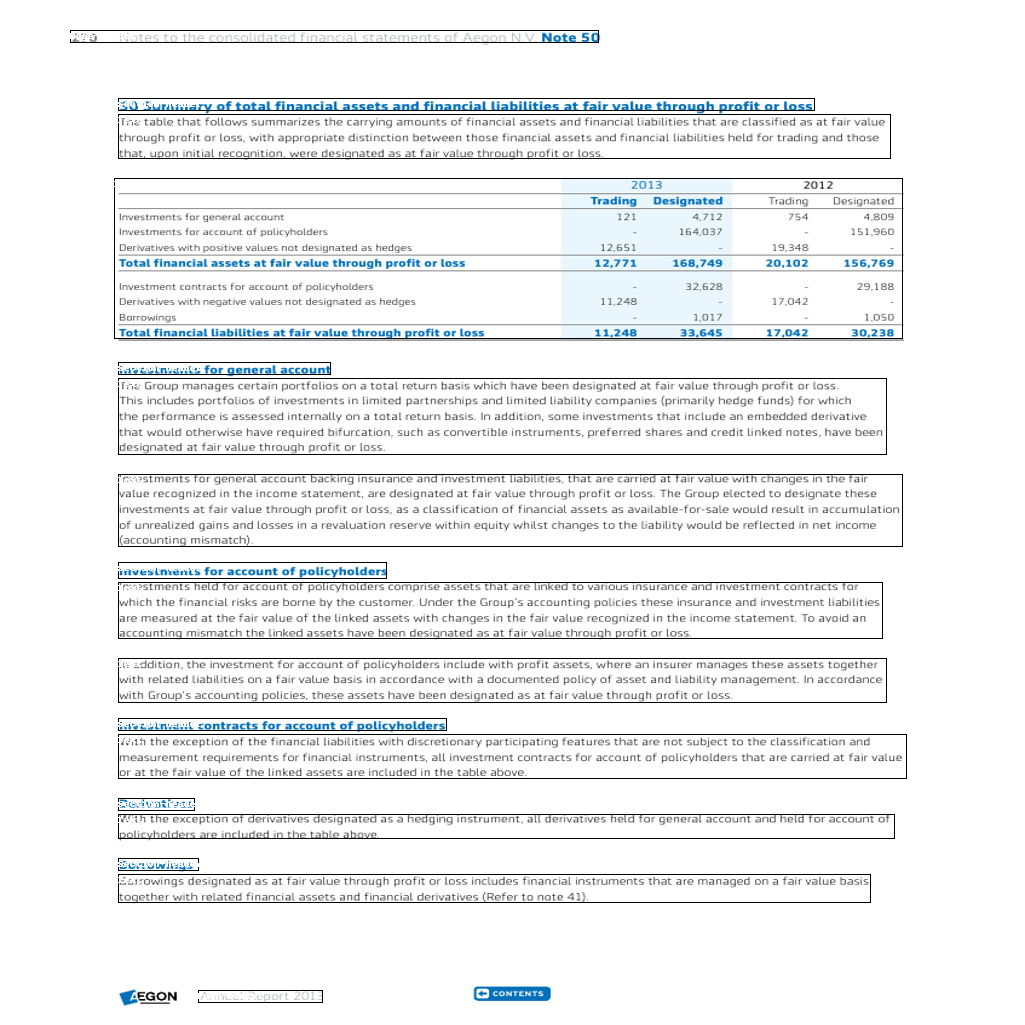

In [ ]:
# By default, the generated text is cleaned up and the entities are extracted.
# processed_text, entities = processor.post_process_generation(test_decode)
processed_text, entities  = clean_text_and_extract_entities_with_bboxes(test_decode.replace("> <", "><"), num_patches_per_side = 32*math.sqrt(total_tokens_increase_by))

print(processed_text)
print(entities)
image = example['image']
width, height = image.size
print(width, height)
draw_ = ImageDraw.Draw(image)

for entity, _, box in entities:
    # print(box)
    box = [round(i, 4) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1*width, x2*width
    y1, y2 = y1*height, y2*height
    draw_.rectangle(xy=((x1, y1), (x2, y2)), outline="black")
    draw_.text(xy=(x1, y1), text=entity)

image

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])


In [ ]:
train_df['type'] = 'train'
val_df['type'] = 'validation'
test_df['type'] = 'test'
all_df = pd.concat([train_df, val_df, test_df])

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 688
    })
    validation: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 63
    })
    test: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 49
    })
})

In [ ]:
def pre_process_data(example_df):

    set_boxs, set_categories = set_cat_box(example_df)
    example_df['float_val'] = [tuple(normalized_box(convert_box(i))) for i in set_boxs]
    example_df['text'] = '<grounding> This image is type of ' + example_df['doc_category'] + '. It has multiple page layouts ' + ", ".join(["<phrase>" + id2label[i] +"</phrase>" for i in set_categories]) + 'in it.'

    # print(encoding)
    return example_df

In [ ]:
all_df = all_df.progress_apply(pre_process_data, axis=1)

100%|██████████| 800/800 [00:01<00:00, 643.08it/s]


In [ ]:
test2_df = all_df[:200]

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from datasets import Dataset

inputs = processor(images = test2_df['image'].to_list(), text = test2_df['text'].to_list(), bboxes = test2_df['float_val'].to_list(), padding=True, truncation= True, return_tensors="pt").to(device)
dataset = Dataset.from_dict(inputs)
train_test_split = dataset.train_test_split(test_size=0.3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
train_test_split

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'input_ids', 'attention_mask', 'image_embeds_position_mask'],
        num_rows: 140
    })
    test: Dataset({
        features: ['pixel_values', 'input_ids', 'attention_mask', 'image_embeds_position_mask'],
        num_rows: 60
    })
})

In [ ]:
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
import torch

example = train_test_split['train'][0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([663])
attention_mask torch.Size([663])
image_embeds_position_mask torch.Size([663])


In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                                    output_dir="./kosmos-finetuned-DocLayNet",# Output directory
                                    max_steps=1000,                              # Maximum number of training steps
                                    per_device_train_batch_size=2,               # Batch size for training
                                    per_device_eval_batch_size=2,                # Batch size for evaluation
                                    learning_rate=1e-5,                          # Learning rate for the optimizer
                                    evaluation_strategy="steps",                 # Evaluate every "eval_steps" steps
                                    eval_steps=100,                              # Evaluate every 250 steps
                                    save_strategy="steps",                       # Save checkpoints every "save_steps" steps
                                    save_steps=100,                             # Save checkpoints every 1000 steps
                                    logging_dir='./logs',                        # Directory for storing logs
                                    logging_steps=250,                           # Log every "logging_steps" steps
                                    load_best_model_at_end=True,                 # Load the best model when finished training
                                    # metric_for_best_model="accuracy",            # Use accuracy as the metric to compare models
                                    # greater_is_better = True,                     # Indicate whether the metric is to be maximized or minimized
                                    warmup_ratio=0.1, # we warmup a bit
                                    # fp16=True, # we use mixed precision (less memory consumption)
                                    push_to_hub=True, # after training, we'd like to push our model to the hub
                                    push_to_hub_model_id=f"kosmos-finetuned-DocLayNet", # this is the name we'll use for our model on the hub
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1834: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case Mit1208/kosmos-finetuned-DocLayNet).
  warnings.warn(


In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):

        # outputs = model(**inputs)
        outputs = model(
            input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"],
            attention_mask=inputs["attention_mask"], image_embeds_position_mask=inputs["image_embeds_position_mask"],
            labels = inputs["input_ids"])
        logits = outputs.logits

        # # Get predicted logits for the next token
        # predicted_logits = logits[:, :-1].contiguous()

        # # Flatten logits and labels for loss computation
        # logits_flat = predicted_logits.view(-1, predicted_logits.size(-1))
        # labels_flat = inputs["input_ids"][:, 1:].contiguous().view(-1)  # Assuming input_ids contains the input sequence

        # # Calculate the cross-entropy loss
        # loss = F.cross_entropy(logits_flat, labels_flat)
        # Ensure that 'eval_loss' is present in the metrics dictionary
        metrics = {'eval_loss': outputs.loss.item()}
        return (outputs.loss, outputs) if return_outputs else outputs.loss

In [ ]:
from transformers import default_data_collator

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
)

# Start training
trainer.train()

Step,Training Loss,Validation Loss
100,No log,No log


KeyError: 'eval_loss'

In [ ]:
from transformers.data.data_collator import default_data_collator


# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_loss=custom_language_modeling_loss,  # Set your custom loss function

)

TypeError: Trainer.__init__() got an unexpected keyword argument 'compute_loss'

In [ ]:
# CUDA_LAUNCH_BLOCKING flag helps to debug GPU error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224", add_eos_token=True, device_map="auto", padding= True)
# from transformers import DataCollatorForLanguageModeling
# data_collator = DataCollatorForLanguageModeling(tokenizer=processor, mlm=False, return_tensors="pt")

# # Initialize our Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=processor.tokenizer,
#     data_collator=data_collator,

# )
# # Start training
# trainer.train()

AttributeError: 'Kosmos2Processor' object has no attribute 'pad'

In [ ]:
test2_df.head(1)

,id,texts,bboxes_block,bboxes_line,categories,image,page_hash,original_filename,page_no,num_pages,original_width,original_height,coco_width,coco_height,collection,doc_category,type,float_val,text
0,0,[Notes to the consolidated financial statement...,"[[71, 30, 529, 14], [71, 30, 529, 14], [71, 30...","[[119, 30, 422, 13], [541, 30, 59, 14], [71, 3...","[5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, ...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,001be94613c0016cdc1dadc399effb005c7c59ffefca45...,NYSE_AEG_2013.pdf,270,358,609,793,1025,1025,ann_reports_10_14_fancy,financial_reports,train,"[(0.116098, 0.701463, 0.434146, 0.714146), (0....",<grounding> This image is type of financial_re...


In [ ]:
from PIL import Image
import requests
import torch
from transformers import AutoProcessor, Kosmos2Model

In [ ]:
all_df.reset_index(drop=True, inplace=True)
text = all_df.loc[0]['text']
image = all_df.loc[0]['image']
bounding_box = all_df.loc[0]['float_val']

In [ ]:
inputs = torch.load('batch_features.pt')

In [ ]:
# image

In [ ]:
text

'<grounding> This image is type of financial_reports. It has multiple page layouts <phrase>Section-header</phrase>, <phrase>Section-header</phrase>, <phrase>Table</phrase>, <phrase>Text</phrase>, <phrase>Section-header</phrase>, <phrase>Page-footer</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Page-header</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Text</phrase>, <phrase>Section-header</phrase>, <phrase>Text</phrase>in it.'

In [ ]:
inputs = processor(text=text, images=image.resize((224, 224)), bboxes = bounding_box,  return_tensors="pt", add_eos_token=True).to(device)

In [ ]:
type(inputs)

transformers.image_processing_utils.BatchFeature

In [ ]:
torch.save(inputs, 'batch_features.pt')

In [ ]:
# from transformers import Kosmos2Model
# model = Kosmos2Model.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)
# last_hidden_state = model(
#              pixel_values=inputs["pixel_values"],
#              input_ids=inputs["input_ids"],
#              attention_mask=inputs["attention_mask"],
#              image_embeds_position_mask=inputs["image_embeds_position_mask"],
#          ).last_hidden_state
# list(last_hidden_state.shape)

[1, 261, 2048]

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):

        outputs = model(**inputs)
        logits = outputs.logits

        # Get predicted logits for the next token
        predicted_logits = logits[:, :-1].contiguous()

        # Flatten logits and labels for loss computation
        logits_flat = predicted_logits.view(-1, predicted_logits.size(-1))
        labels_flat = inputs["input_ids"][:, 1:].contiguous().view(-1)  # Assuming input_ids contains the input sequence

        # Calculate the cross-entropy loss
        loss = F.cross_entropy(logits_flat, labels_flat)

        return (loss, outputs) if return_outputs else loss

In [ ]:
generated_ids = model.forward(
             pixel_values=inputs["pixel_values"],
             input_ids=inputs["input_ids"],
             attention_mask=inputs["attention_mask"],
             image_embeds=None,
             image_embeds_position_mask=inputs["image_embeds_position_mask"],
             use_cache=True,
             labels = inputs["input_ids"],
         )

The `use_cache` argument is changed to `False` since `labels` is provided.


In [ ]:
generated_ids = model.forward(
             pixel_values=inputs["pixel_values"],
             input_ids=inputs["input_ids"],
             attention_mask=inputs["attention_mask"],
             image_embeds=None,
             image_embeds_position_mask=inputs["image_embeds_position_mask"],
             use_cache=True,
             labels = torch.cat((inputs["input_ids"][:, 1:].contiguous().view(-1), torch.tensor([1]).to(device)))
         )

The `use_cache` argument is changed to `False` since `labels` is provided.


In [ ]:
generated_ids.loss

tensor(3.8531, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
processor.tokenizer.pad_token_id

1

In [ ]:
outputs = model(**inputs)
logits = outputs.logits

# Get predicted logits for the next token
predicted_logits = logits[:, :-1].contiguous()

# Flatten logits and labels for loss computation
logits_flat = predicted_logits.view(-1, predicted_logits.size(-1))
labels_flat = inputs["input_ids"][:, 1:].contiguous().view(-1)  # Assuming input_ids contains the input sequence

In [ ]:
import torch.nn.functional as F
# Calculate the cross-entropy loss
loss = F.cross_entropy(logits_flat, labels_flat)

print(loss)

tensor(3.8531, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
generated_ids.logits

tensor([[[ 2.9209e+00, -5.4381e+00,  2.8645e+00,  ..., -2.6197e+00,
          -2.6742e+00, -1.6857e+00],
         [ 4.6663e-03, -5.0998e+00,  4.3386e+00,  ..., -2.2520e+00,
          -2.2430e+00, -1.5341e+00],
         [ 1.0861e-01, -4.5480e+00,  4.6287e+00,  ..., -2.5333e+00,
          -2.3700e+00, -2.3920e+00],
         ...,
         [-6.5301e-01, -4.7070e+00,  1.5316e+01,  ..., -2.8818e+00,
          -3.1680e+00, -1.3414e+00],
         [-2.2748e+00, -5.3688e+00,  1.6432e+01,  ..., -2.1442e+00,
          -2.3198e+00, -1.1153e+00],
         [ 3.7230e-01, -5.6333e+00,  5.7560e+00,  ..., -2.7190e+00,
          -2.7617e+00, -2.1346e+00]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
for i, j in generated_ids.items():
  print(i)

logits
past_key_values
image_embeds
projection_attentions
vision_model_output


In [ ]:

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
processed_text


TypeError: argument 'ids': Can't extract `str` to `Vec`

In [ ]:
print(trainer.args.fp16)

True


# Ignore

## Load image and prompt

Let's start by illustrating image grounding. We'll load an image and provide a text prompt for the model to complete. For image grounding, one can specify the special \<grounding> token (which was used during training). Refer to section 3.1 in the [paper](https://arxiv.org/abs/2306.14824) for details on how grounded image-text pairs are represented for the model.

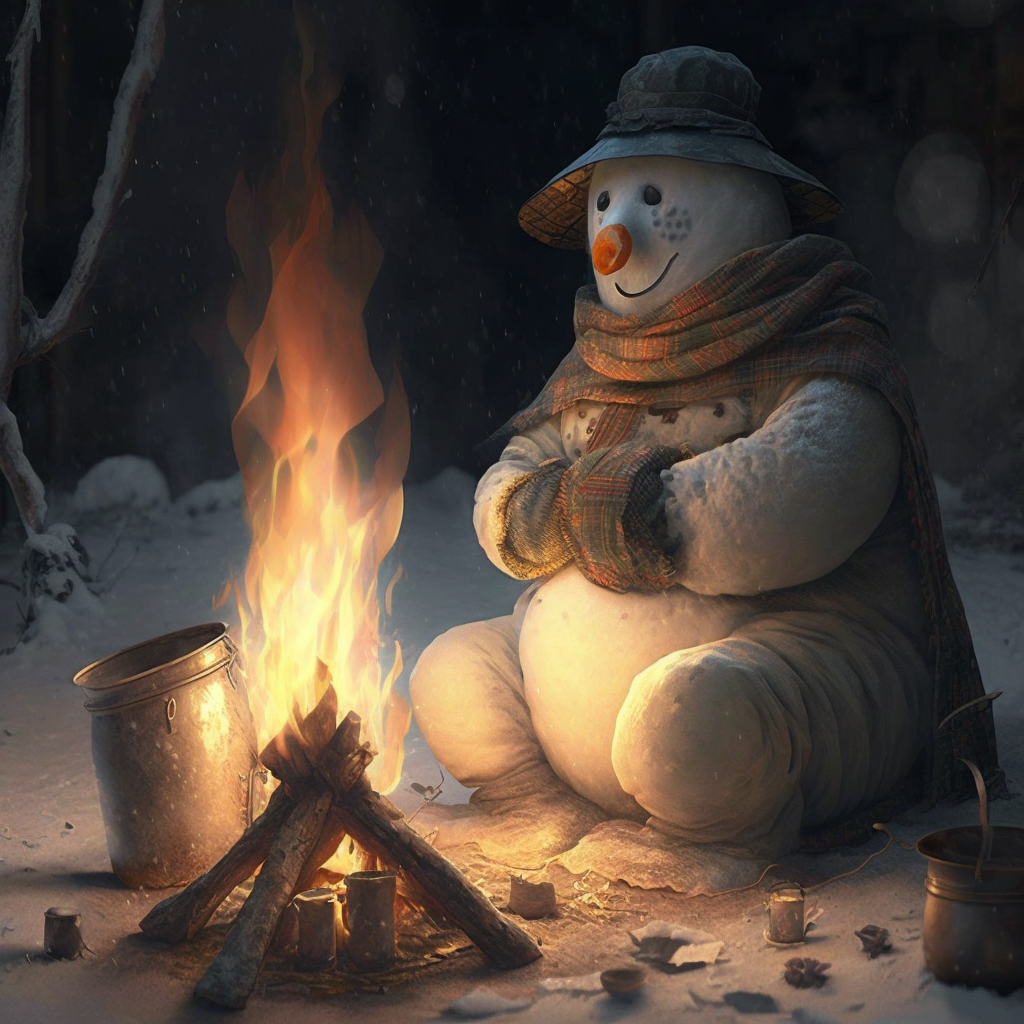

In [ ]:
prompt = "<grounding>An image of"

url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)
image

## Generate completion

Next, we prepare the image and text prompt for the model using the processor, and then let the model autoregressively (which means, token by token) generate a completion.

In [ ]:
prompt

'<grounding>An image of'

In [ ]:
image2 = Image.open("t1.png")
image2

In [ ]:
processor(text=prompt, images=image, return_tensors="pt")

In [ ]:
inputs = processor(text=prompt, images=image2, return_tensors="pt").to("cuda:0")

# autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a document</phrase><object><patch_index_0000><patch_index_1023></object> from the FBI


In [ ]:
generated_text

'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>'

In [ ]:
generated_text

'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a document</phrase><object><patch_index_0000><patch_index_1023></object> from the FBI'

In [ ]:
for i, j in inputs.items():
    print(i, j.shape)

pixel_values torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 71])
attention_mask torch.Size([1, 71])
image_embeds_position_mask torch.Size([1, 71])


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,#LoRA scaling factor
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)
peft_model = get_peft_model(model,
                            lora_config)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./test",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    max_steps =1
)



In [ ]:
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


As we can see, the first tokens don't make any sense. This is because those tokens correspond to the image patches (the model marks the start and end of these with special \<image> and \</image> tokens), which the model also gets as input. The model basically gets (start of image token, image patch token 1, image patch token 2, ..., end of image token, grounding token, ... text token 1, text token 2, ...) as input and is trained to predict the next text token. The model itself was trained on the [GRIT dataset](https://huggingface.co/datasets/zzliang/GRIT), available on 🤗.

We only need to take a look at the tokens after that:

In [ ]:
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


As can be seen, the model complets the sentence by generating not only text tokens, but also special tokens like \<phrase> and \<object>, together with certain location tokens like \<patch_index_0044>.

This is exactly what the `post_process_generation` method provides as well in case you specify `cleanup_and_extract=False`:

In [ ]:
# Specify `cleanup_and_extract=False` in order to see the raw model generation.
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)

print(processed_text)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


Now, what do tokens like \<patch_index_0044> mean? Refer to the following section of the paper:

> The image resolution is set to 224×224 and the patch size is 14×14. We divide the width and height of the image into 32 bins, with each bin consisting of 7×7 pixels. A total of 32×32 location tokens are added to the vocabulary.

So basically, the model is able to spit out 32x32 possible location tokens to indicate where certain objects can be. Patch index 0044 is one of them.

To turn the raw location tokens into actual bounding boxes that can be plotted on an image, we can leverage the post_process_generation method, this time specifying to clean up and extract all entities. Note that the bounding boxes are in (x1, y1, x2, y2) format, normalized by the size of the image:

In [ ]:
1280*1280   10*10
5*5    256*256


In [ ]:
test_decode

'<s><image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> This image is type of financial_reports. It has multiple page layouts<phrase> Section-header</phrase><object> <patch_index_184224> <patch_index_189887></object>,<phrase> Section-header</phrase><object> <patch_index_204704> <patch_index_208351></object>,<phrase> Table</phrase><object> <patch_index_45952> <patch_index_93183></object>,<phrase> Text</phrase><object> <patch_index_149408> <patch_index_169823></object>,<phrase> Section-header</phrase><object> <patch_index_220064> <patch_index_223743></object>,<phrase> Page-footer</phrase><object> <patch_index_254496> <patch_index_258527></object>,<phrase> Section-header</phrase><object> <patch_index_93088> <patch_index_97823></object>,<phrase> Text</phrase><object> <patch_index_97184> <patch_inde

In [ ]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(test_decode)

print(processed_text)
print(entities)

This image is type of financial_reports. It has multiple page layouts Section-header, Section-header, Table, Text, Section-header, Page-footer, Section-header, Text, Text, Text, Page-header, Section-header, Text, Text, Text, Section-header, Text in it.
[('Section-header', (70, 84), [(0.09375, 0.6875, 0.4375, 0.71875)]), ('Section-header', (86, 100), [(0.109375, 0.765625, 0.203125, 0.796875)]), ('Table', (102, 107), [(0.109375, 0.171875, 0.890625, 0.328125)]), ('Text', (109, 113), [(0.109375, 0.578125, 0.859375, 0.609375)]), ('Section-header', (115, 129), [(0.109375, 0.828125, 0.203125, 0.859375)]), ('Page-footer', (131, 142), [(0.203125, 0.953125, 0.328125, 0.984375)]), ('Section-header', (144, 158), [(0.09375, 0.34375, 0.34375, 0.375)]), ('Text', (160, 164), [(0.109375, 0.359375, 0.859375, 0.453125)]), ('Text', (166, 170), [(0.109375, 0.453125, 0.890625, 0.546875)]), ('Text', (172, 176), [(0.109375, 0.640625, 0.859375, 0.671875)]), ('Page-header', (178, 189), [(0.078125, 0.015625, 0.5

In [ ]:
(0.390625 * 224, 0.046875 * 224, 0.984375 * 224, 0.828125 * 224)

(87.5, 10.5, 220.5, 185.5)

## Check dataset

1024 693


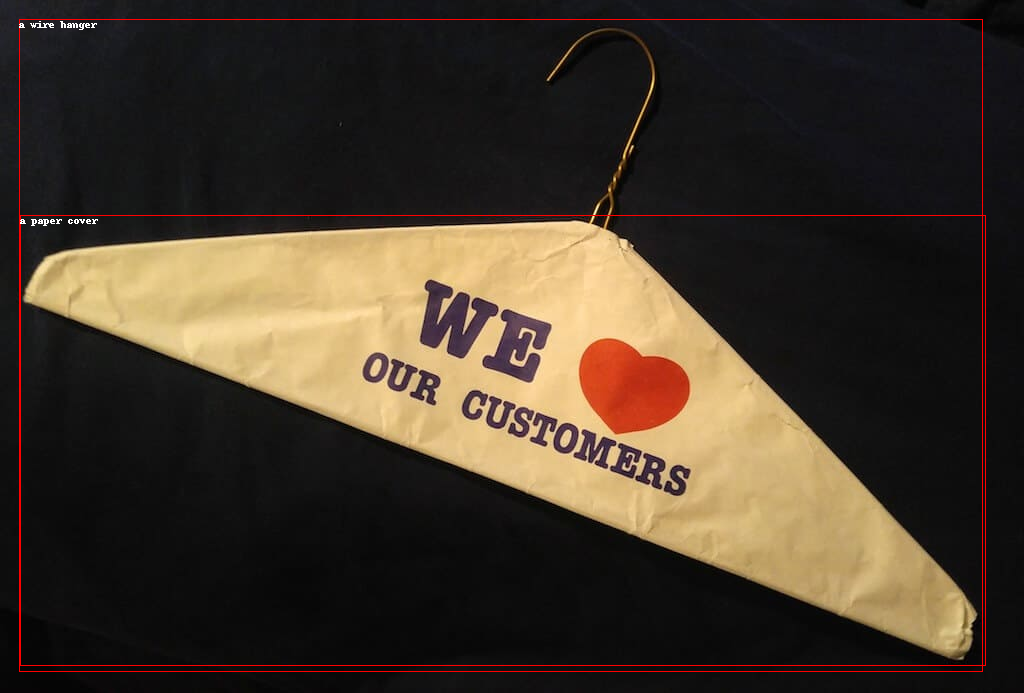

In [ ]:
from PIL import ImageDraw
# https://huggingface.co/datasets/zzliang/GRIT?row=29

x = 'a wire hanger with a paper cover that reads we heart our customers'
list_l = [[19, 32, 0.019644069503434333, 0.31054004033406574, 0.9622142865754519, 0.9603442351023356, 0.79298526], [0, 13, 0.019422357885505368, 0.027634161214033764, 0.9593302408854166, 0.969467560450236, 0.67520964]]
image = Image.open(requests.get("https://www.thestrapsaver.com/wp-content/uploads/customerservice-1.jpg", stream=True).raw)

width, height = image.size
print(width, height)
draw = ImageDraw.Draw(image)

for entity_cord in list_l:
    entity = x[entity_cord[0]:entity_cord[1]]
    box = entity_cord[2:6]
    # box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1*width, x2*width
    y1, y2 = y1*height, y2*height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image